In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

2025-07-21 09:45:43.516184: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 09:45:44.583844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753112744.866191   91151 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753112745.025147   91151 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 09:45:46.039434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
#======================== set up ============================
# get parameter information
with open(utils_dir+"/param_names.pkl", "rb") as f:
    param_info = pickle.load(f)
u_params = param_info['u_params']
pft_params = param_info['pft_params']

# get biome information
with open("./biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

# get observations
obs_biome = xr.open_dataset('calibration_obsStatistics_sudokuBiomes_v3.nc')

# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('default_params_norm.csv', index_col=False)
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]
default_params.loc[0, ['xl_12']] = [0]

### load calibrated sets

In [6]:
cal_params = pd.read_csv('../paramsets/caltest_46-53.csv')

In [3]:
cal_params = pd.read_csv('./checkpoints_sudoku_v2_r3/calibrated_sets_lambda20_071425.csv')

In [7]:
np.mean(np.sum(np.abs(cal_params- np.tile(default_params,(8,1))),axis=1))

26.266653080070142

In [3]:
with open("./checkpoints_sudoku_v3_r1/checkpoint_step_1950.pkl", "rb") as f:
    check = pickle.load(f)

2025-07-21 09:47:14.117000: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
params = check['params'].numpy()
universal_params = np.tile(default_params[u_params].iloc[[0]].to_numpy(),(len(params),1))
master_params = np.concatenate([universal_params,params],axis=1)
cal_params = pd.DataFrame(master_params, columns = default_params.columns)

### Emulate to check

In [5]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')

infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku3_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)

# drop crashers
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
ix = np.where(ds_lhc.crashed==1)[0]
params_lhc = params.drop(ix-1)

lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()
gpp_lhc = (60*60*24)*lhc_pxb.GPP_biome_amean.sel(year=slice('2001','2015')).mean(dim='year').compute()
tvc_lhc = (1/1000)*lhc_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')).mean(dim='year').compute()

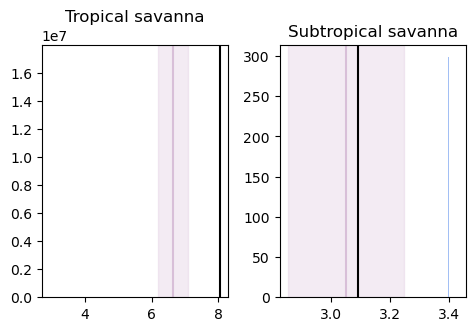

In [9]:
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/calibration/calibration_july/emulators_biomelai_compiled/'

plt.figure(figsize=(12,9))
for b,biome in enumerate(biome_configs[2:4],start=1):
    biome_name = biome['name']
    plt.subplot(3,5,b)

    obs_mean = 1.1*obs_biome.LAI_mean.sel(biome=b).values
    obs_var = obs_biome.LAI_stdev.sel(biome=b).values**2

    pfts = biome['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = cal_params[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome_name)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp)

    #plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-obs_var**0.5,obs_mean+obs_var**0.5,color='thistle',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    plt.axvline(lai_lhc.isel(ens=0,biome=b),color='k')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    #plt.axvline(lai_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=True)
    
    plt.title(biome_name)

plt.tight_layout()
#plt.savefig('./checkpoints_sudoku_v2_r3/CalCheck_LAI.png')

In [8]:
np.shape(y_pred)

TensorShape([1000, 1])

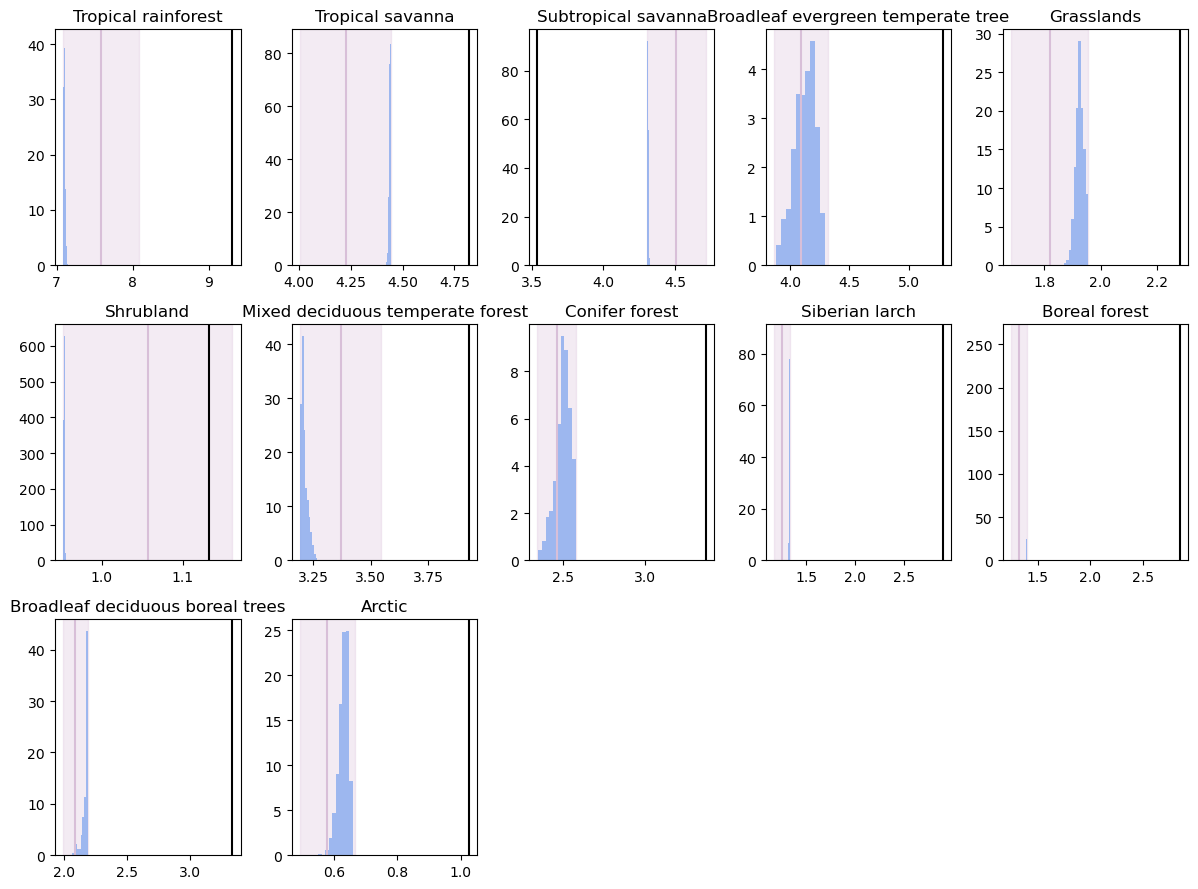

In [7]:
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/calibration/calibration_july/emulators_biomegpp_compiled/'

plt.figure(figsize=(12,9))
for b,biome in enumerate(biome_configs[1:],start=1):
    biome_name = biome['name']
    plt.subplot(3,5,b)

    obs_mean = obs_biome.GPP_mean.sel(biome=b).values
    obs_var = obs_biome.GPP_stdev.sel(biome=b).values**2

    pfts = biome['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = cal_params[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome_name)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp)

    #plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-obs_var**0.5,obs_mean+obs_var**0.5,color='thistle',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    plt.axvline(gpp_lhc.isel(ens=0,biome=b),color='k')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    #plt.axvline(lai_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=True)
    
    plt.title(biome_name)

plt.tight_layout()
#plt.savefig('./checkpoints_sudoku_v2_r3/CalCheck_GPP.png')

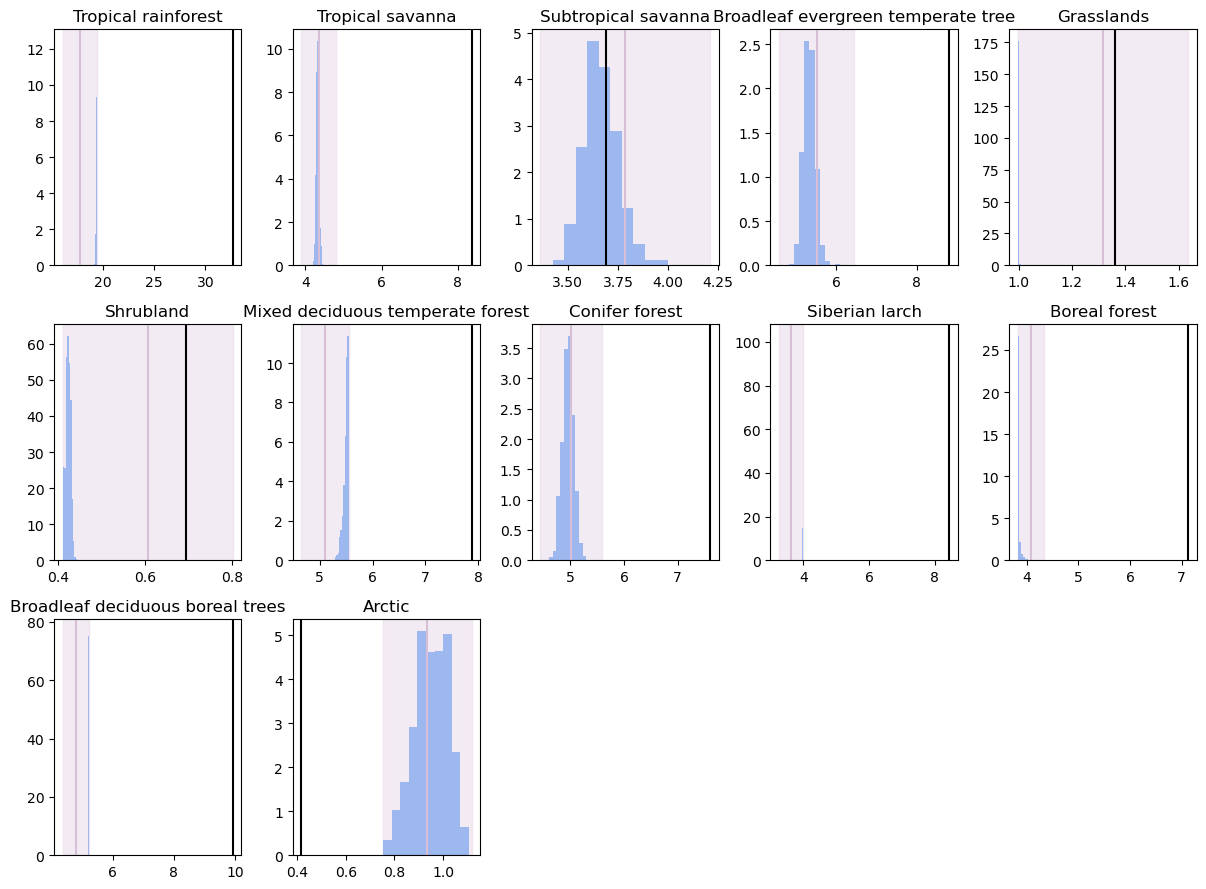

In [8]:
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/calibration/calibration_july/emulators_biomebiomass_compiled/'

plt.figure(figsize=(12,9))
for b,biome in enumerate(biome_configs[1:],start=1):
    biome_name = biome['name']
    plt.subplot(3,5,b)

    obs_mean = obs_biome.TVC_mean.sel(biome=b).values
    obs_var = obs_biome.TVC_stdev.sel(biome=b).values**2

    pfts = biome['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = cal_params[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome_name)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp)

    #plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-obs_var**0.5,obs_mean+obs_var**0.5,color='thistle',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    plt.axvline(tvc_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=True)
    
    plt.title(biome_name)

plt.tight_layout()
#plt.savefig('./checkpoints_sudoku_v2_r3/CalCheck_biomass.png')

### Plot posteriors

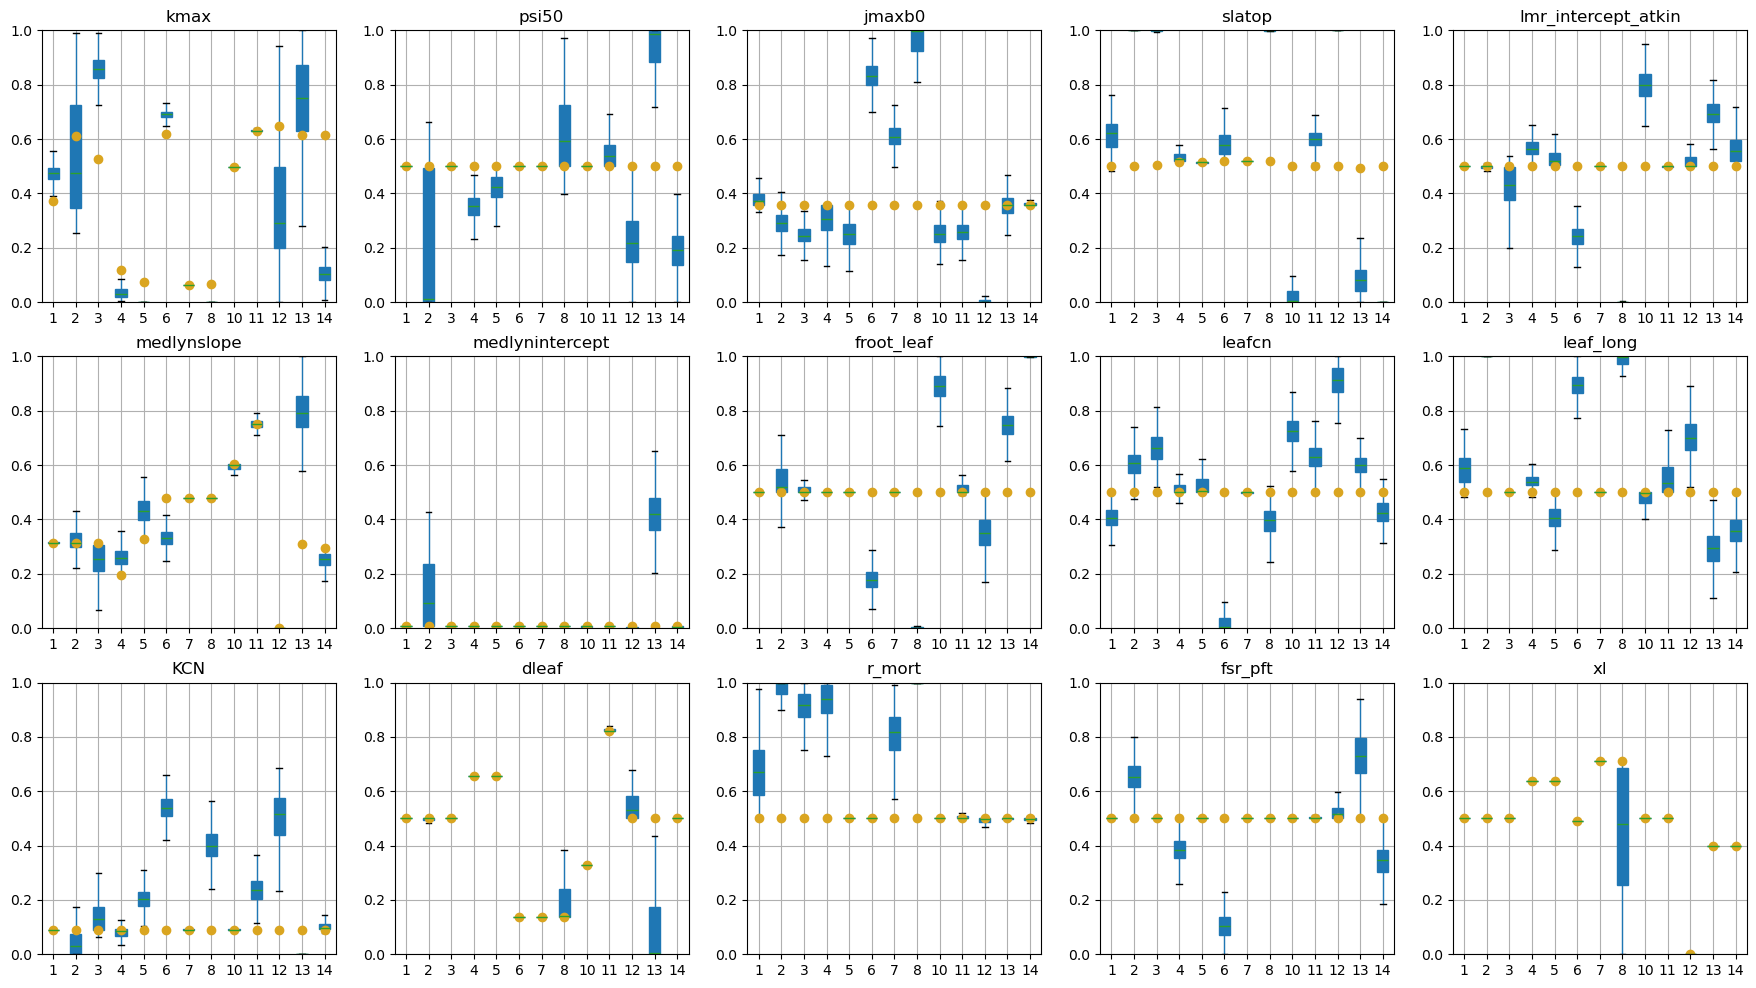

In [9]:
plt.figure(figsize=(22, 12))
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]

for j, param in enumerate(pft_params):
    plt.subplot(3, 5, j+1)
    pft_param_names = [f"{param}_{pft}" for pft in pft_ids]
    data = cal_params[pft_param_names]
    
    ax = plt.gca()
    data.boxplot(showfliers=False, patch_artist=True, ax=ax)

    # Style the boxes
    for patch in ax.artists:
        patch.set_facecolor('cornflowerblue')
        patch.set_edgecolor('cornflowerblue')

    # Overlay default values
    for i, col in enumerate(data.columns):
        plt.plot(i + 1, default_params[col], 'o', color='goldenrod')  # x is 1-based
    plt.ylim([0,1])

    plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=pft_ids, rotation=0)
    plt.title(param)
plt.savefig('./checkpoints_sudoku_v2_r3/posteriors_byParam.png', dpi=300)

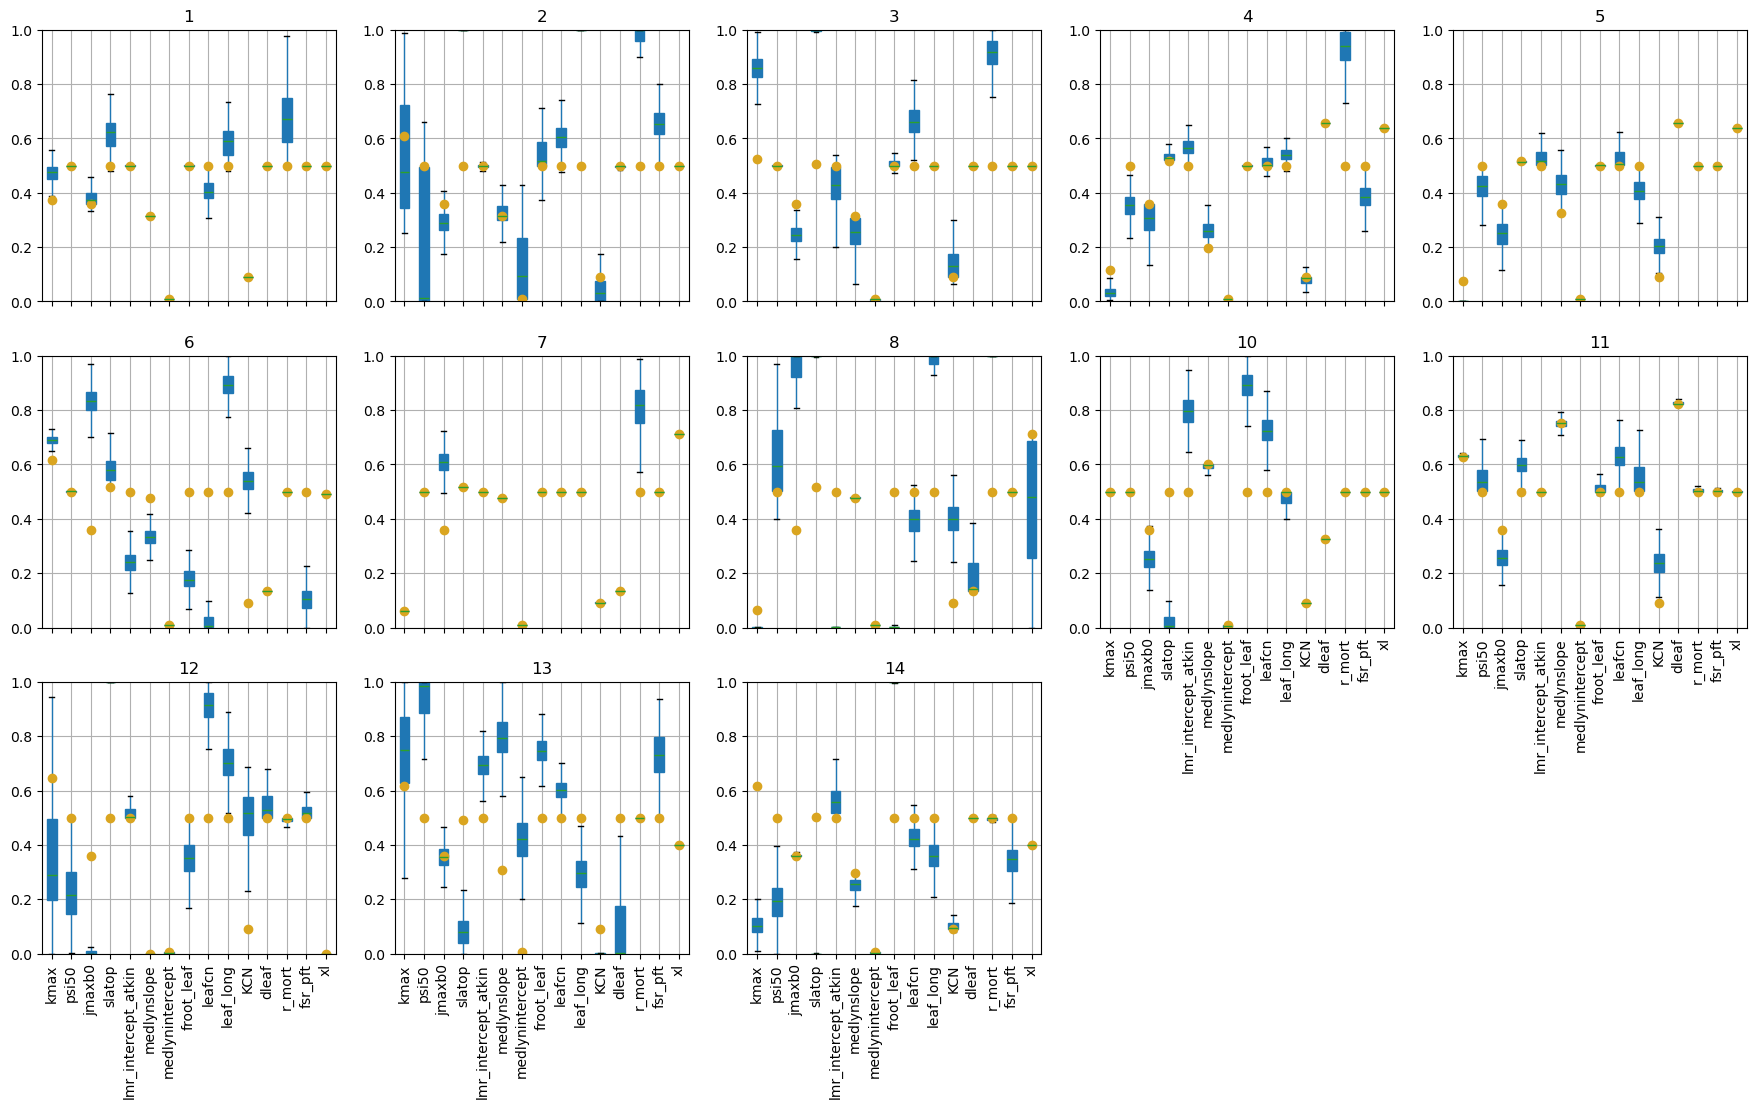

In [10]:
plt.figure(figsize=(22, 12))
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]

for j, pft in enumerate(pft_ids):
    plt.subplot(3, 5, j+1)
    pft_param_names = [f"{param}_{pft}" for param in pft_params]
    data = cal_params[pft_param_names]
    
    ax = plt.gca()
    data.boxplot(showfliers=False, patch_artist=True, ax=ax)

    # Style the boxes
    for patch in ax.artists:
        patch.set_facecolor('cornflowerblue')
        patch.set_edgecolor('cornflowerblue')

    # Overlay default values
    for i, col in enumerate(data.columns):
        plt.plot(i + 1, default_params[col], 'o', color='goldenrod')  # x is 1-based

    if pft>8:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=pft_params, rotation=90)
    else:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1),labels=[])

    plt.ylim([0,1])
    plt.title(pft)
plt.savefig('./checkpoints_sudoku_v2_r3/posteriors_byPFT.png', dpi=300)

### Cluster across other metrics

In [11]:
paths = {
    'vcmx25z': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/vcmx25z',
    'cue': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/cue/',
    'ncost': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/ncost/',
    'alloc': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/alloc/',
    'wstress': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_global/wstress/',
}

vars = ['vcmx25z','cue','ncost','alloc','wstress']
out_data = {var: [] for var in vars}

cols = default_params.columns
samp = cal_params[cols]

for var in vars:
    emulator = tf.saved_model.load(f"{paths[var]}")
    y_pred, _ = emulator.predict(samp)
    out_data[var].append(y_pred.numpy().squeeze())


In [12]:
# Now convert to Dataset
n_samp = out_data[vars[0]][0].shape[0]
samples = np.arange(n_samp)

ds_vars = {}
for var in vars:
    data_array = out_data[var][0]
    ds_vars[var] = (['sample'], data_array)

ds = xr.Dataset(ds_vars, coords={'sample': samples})


In [15]:
from sklearn.cluster import KMeans
import itertools
from sklearn.preprocessing import StandardScaler

In [16]:
#(n_samples, n_vars)
nClusters=4
X = np.stack([
    ds['vcmx25z'].values,
    ds['cue'].values,
    ds['ncost'].values,
    ds['alloc'].values,
    ds['wstress'].values
], axis=1)

# Normalize 
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Cluster the samples
kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(X_norm)
labels = kmeans.labels_  # shape: (n_samples,)

# add to dataset
ds['cluster'] = ('sample', labels)

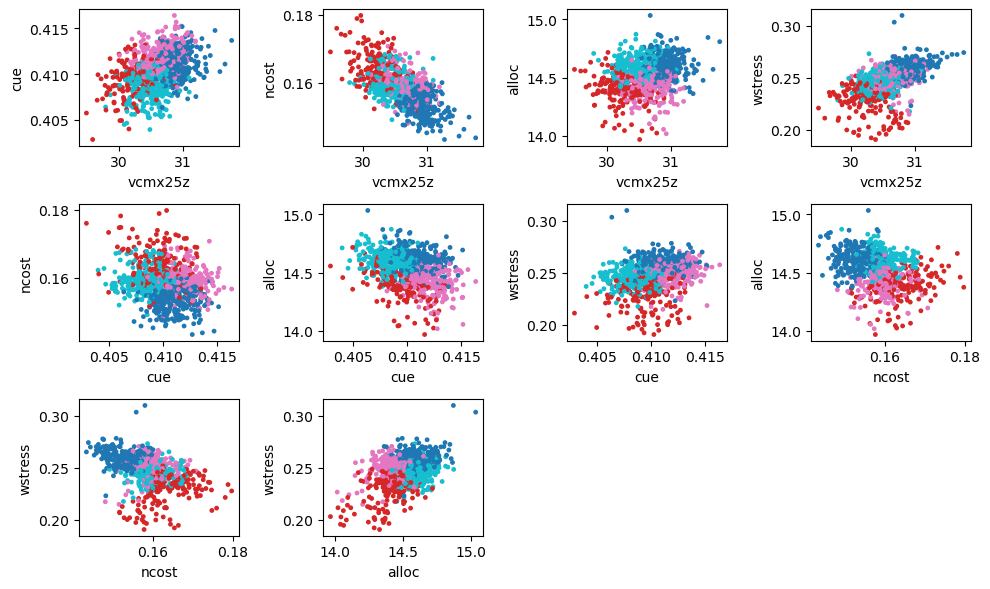

In [17]:
n_vars = X.shape[1]
pairs = list(itertools.combinations(range(n_vars), 2))
n_plots = len(pairs)

fig = plt.figure(figsize=(10, 6))

for idx, (i, j) in enumerate(pairs, start=1):
    ax = fig.add_subplot(3, 4, idx)
    ax.scatter(X[:, i], X[:, j], s=6, c=labels, cmap='tab10')
    ax.set_xlabel(vars[i])
    ax.set_ylabel(vars[j])

plt.tight_layout()
plt.savefig('./checkpoints_sudoku_v2_r3/clusters_Global_metricspace.png',dpi=300)

### Select parameter sets

In [18]:
labels = ds['cluster'].values
clusters = np.unique(labels)

# pick 2 random indices per cluster
selected_idxs = []
rng = np.random.default_rng(seed=0) 
for c in clusters:
    # find all sample-positions belonging to cluster c
    idxs = np.where(labels == c)[0]
    if len(idxs) >= 2:
        chosen = rng.choice(idxs, size=2, replace=False)
    else:
        # if fewer than 2 members, just take them all
        chosen = idxs
    selected_idxs.extend(chosen.tolist())

selected_idxs = np.array(selected_idxs, dtype=int)
print("Selected sample indices:", selected_idxs)


Selected sample indices: [848 658 303 275  35  82 806 653]


In [19]:
#check
cols = default_params.columns
samp = cal_params[cols].iloc[selected_idxs]

emulator = tf.saved_model.load(f"{paths['wstress']}")
y_pred, _ = emulator.predict(samp)
retest = y_pred.numpy().squeeze()
print(retest)
print(ds['wstress'].isel(sample=selected_idxs).values)

[0.25330913 0.26141143 0.23814601 0.23513574 0.25761625 0.24819868
 0.23949039 0.22605005]
[0.25330913 0.26141143 0.23814601 0.23513574 0.25761625 0.24819868
 0.23949039 0.22605005]


In [20]:
samp

,jmaxb1,wc2wjb0,grperc,theta_cj,tpu25ratio,lmrse,vcmaxha,jmaxha,tpuha,lmrha,...,xl_4,xl_5,xl_6,xl_7,xl_8,xl_10,xl_11,xl_12,xl_13,xl_14
848,0.4,0.18022,0.24,0.7,0.0,0.888889,0.6,0.363636,0.516746,0.5,...,0.638511,0.638889,0.492064,0.712,0.221254,0.500374,0.501941,0.0,0.400024,0.400171
658,0.4,0.18022,0.24,0.7,0.0,0.888889,0.6,0.363636,0.516746,0.5,...,0.638465,0.638889,0.492064,0.712,0.386677,0.500000,0.500334,0.0,0.400450,0.400105
303,0.4,0.18022,0.24,0.7,0.0,0.888889,0.6,0.363636,0.516746,0.5,...,0.638889,0.638889,0.492063,0.712,0.663116,0.500000,0.500251,0.0,0.400000,0.400000
275,0.4,0.18022,0.24,0.7,0.0,0.888889,0.6,0.363636,0.516746,0.5,...,0.638421,0.638889,0.492063,0.712,0.227632,0.500084,0.503872,0.0,0.400000,0.400000
35,0.4,0.18022,0.24,0.7,0.0,0.888889,0.6,0.363636,0.516746,0.5,...,0.638889,0.638889,0.492064,0.712,0.598522,0.500000,0.500000,0.0,0.400000,0.400000
82,0.4,0.18022,0.24,0.7,0.0,0.888889,0.6,0.363636,0.516746,0.5,...,0.638889,0.638889,0.492064,0.712,0.655437,0.500000,0.500366,0.0,0.400063,0.400000
806,0.4,0.18022,0.24,0.7,0.0,0.888889,0.6,0.363636,0.516746,0.5,...,0.638889,0.638889,0.492064,0.712,0.142228,0.500000,0.506415,0.0,0.399869,0.399987
653,0.4,0.18022,0.24,0.7,0.0,0.888889,0.6,0.363636,0.516746,0.5,...,0.638889,0.638889,0.492063,0.712,0.180707,0.500000,0.502154,0.0,0.400000,0.400000


In [21]:
samp.to_csv('../paramsets/caltest_34-41.csv')

### Write param sets

In [10]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

In [11]:
csv='~/ctsm6_ppe/gen_ensembles/gen_paramfiles/ctsm6cal_paramranges_05122025.csv'
df = pd.read_csv(csv)
df_main = df[df['include'] == 1]
params=df_main['param'].values

In [20]:
params = np.concatenate([np.array(['TAU']), params])

In [21]:
filename = '../paramsets/caltest_46-53.csv'
selected_paramsets = pd.read_csv(filename)

In [22]:
# create dictionary of paramsets
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]
pset_dict = {}

for param in params:
    if param in pft_params:
        psets = np.ones((len(selected_paramsets),79))*0.5
        cols = [f"{param}_{i}" for i in pft_ids]
        psets[:,pft_ids] = selected_paramsets[cols].values
        pset_dict[param] = psets
    else:
        pset_dict[param] = selected_paramsets[param].values

In [24]:
# fix some individual PFTs/params
extra_pfts = [0,9,16]
for i in range(1):
    pset_dict['medlynintercept'][i][extra_pfts]= 0.08
# set c3 crops equivalent to c3 grasses
for par in pft_params:
    pset_dict[par][:,15] = pset_dict[par][:,13]

In [25]:
np.save('../paramsets/caltest_46-53.npy', pset_dict)

### Plot posteriors of caltests

In [28]:
import matplotlib.cm as cm
import matplotlib.colors as colors
colors = [cm.viridis(i) for i in np.linspace(0, 1, 8)]

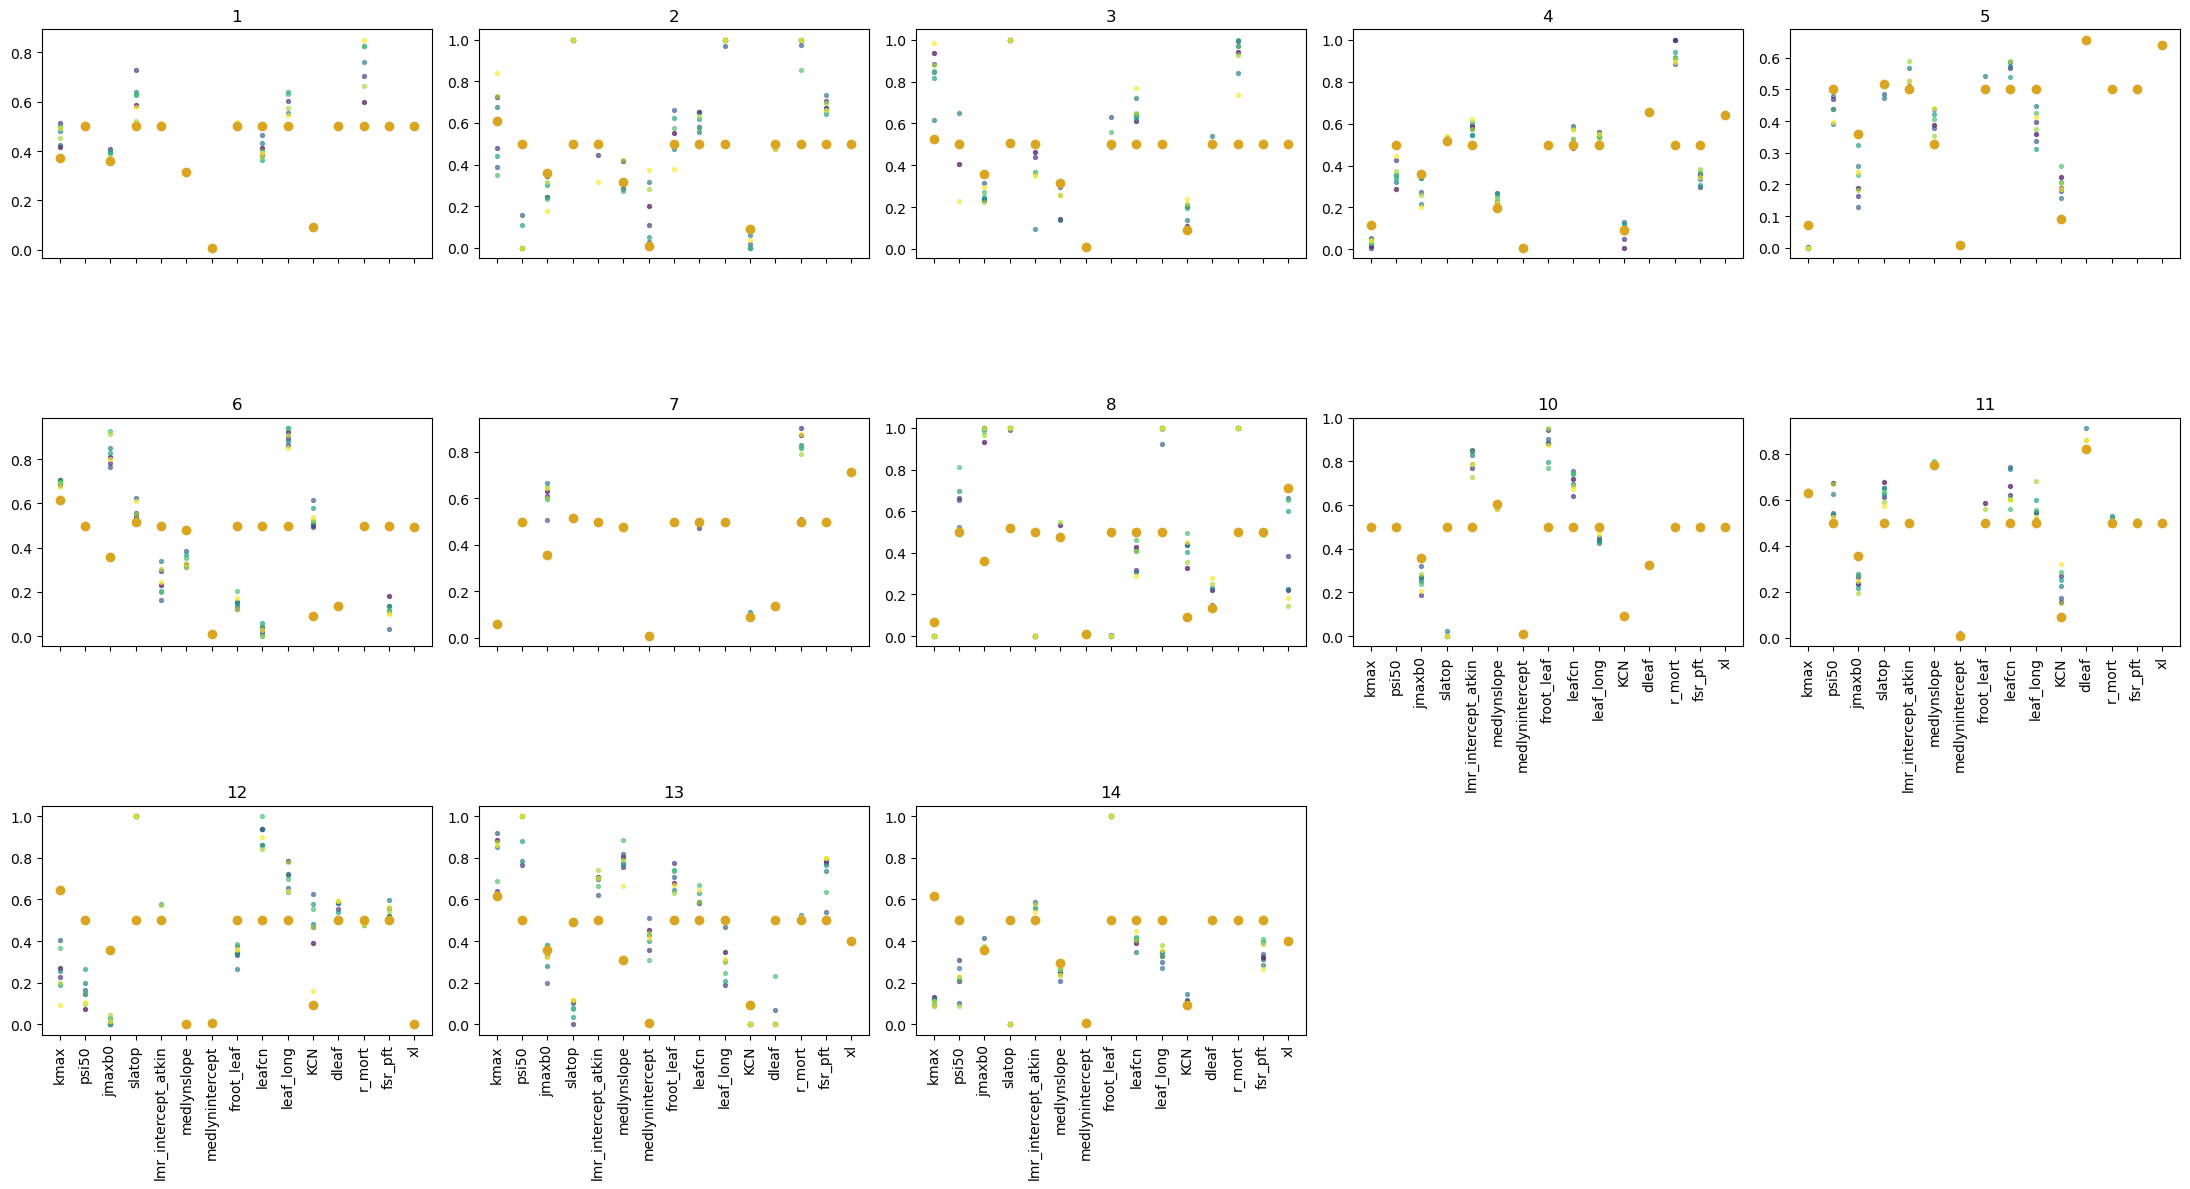

In [29]:
plt.figure(figsize=(22, 12))
pft_ids = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14]

for j, pft in enumerate(pft_ids):
    plt.subplot(3, 5, j+1)
    pft_param_names = [f"{param}_{pft}" for param in pft_params]
    data = selected_paramsets[pft_param_names]

    # Plot dots instead of boxplots
    for i, col in enumerate(data.columns):
        # plot default value
        plt.plot(i + 1, default_params[col], 'o', color='goldenrod')

        # plot calibrated values
        x_vals = np.full_like(data[col], i + 1, dtype=float)
        for j in range(len(x_vals)):
            plt.scatter(x_vals[j], data[col].iloc[j], s=8, alpha=0.6,color = colors[j])

    if pft > 8:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=pft_params, rotation=90)
    else:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=[])

    plt.title(pft)

plt.tight_layout()
plt.savefig('../paramsets/caltest_34-41_posteriors.png', dpi=300)
